In [1]:
# Import required libraries

# Standard
from collections import Counter
from glob import glob
from itertools import combinations

# External
from graphviz import Digraph

import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

import networkx as nx
from networkx.algorithms.clique import find_cliques as maximal_cliques
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np

import pandas as pd

from scipy.sparse import csr_matrix
from scipy.stats import fisher_exact, describe, pearsonr
from sklearn.cross_decomposition import CCA


In [2]:
# Global configurations
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
# Define utility functions
def in_graph(G, title, authors, year):
    '''
    ARGUMENTS
        G (nx.Graph or DiGraph): Graph or digraph to query
        title (str): Title query
        authors (str): Author query
        year (int): Year query

    RETURNS
        (bool): Wether query article is already in graph
    '''
    if title not in nx.get_node_attributes(G, 'title').values():
        return False
    elif not set(authors.split('; ')) in [set(authors.split(';'))\
                                          for authors in nx.get_node_attributes(citation, 'authors').values()]:
        return False
    elif not year in nx.get_node_attributes(citation, 'year').values():
        return False
    else:
        return True

def get_nodes_by_attribute(G, attr, val):
    return [i for i,j in nx.get_node_attributes(G, attr).items() if j == val]

## Construct Graphs

In [4]:
# Construct citation graph
CURRENT_path = '/home/galen/Dropbox/UNBC/Research_Methods/CURRENT/'
FORWARD_path = '/home/galen/Dropbox/UNBC/Research_Methods/FORWARD/'
BACKWARD_path = '/home/galen/Dropbox/UNBC/Research_Methods/BACKWARD/'

citation = nx.DiGraph()

print('Adding nodes to citation network from CURRENT')
count = 0
for file in glob(CURRENT_path + '*.csv'):
    article = file.replace('.csv', '').split('/')[-1]
    try:
        df = pd.read_csv(file)
        for row in df.iterrows():
            title, authors, year = list(row[1][['Article Title', 'Authors', 'Publication Year']])
            keywords = set()
            if not pd.isna(row[1]['Author Keywords']):
                keywords.update(row[1]['Author Keywords'].lower().split('; '))
            if not pd.isna(row[1]['Keywords Plus']):
                keywords.update(row[1]['Keywords Plus'].lower().split('; '))
            if not in_graph(citation, title, authors, year):
                citation.add_node(count,
                                  title=title,
                                  authors=authors.replace('; ', ';'),
                                  year=year,
                                  keywords=';'.join(keywords))
                count += 1
    except pd.errors.EmptyDataError:
        continue

print('Getting edges to citation network from FORWARD')
for file in glob(FORWARD_path + '*.csv'):
    article = file.replace('.csv', '').split('/')[-1]
    df = pd.read_csv(file)
    for row in df.iterrows():
        title, authors, year = list(row[1][['Article Title', 'Authors', 'Publication Year']])
        keywords = set()
        if not pd.isna(row[1]['Author Keywords']):
            keywords.update(row[1]['Author Keywords'].lower().split('; '))
        if not pd.isna(row[1]['Keywords Plus']):
            keywords.update(row[1]['Keywords Plus'].lower().split('; '))
        if not in_graph(citation, title, authors, year):
            citation.add_node(count,
                              title=title,
                              authors=authors.replace('; ', ';'),
                              year=year,
                              keywords=';'.join(keywords))
            count += 1
        citation.add_edge(get_nodes_by_attribute(citation, 'title', title)[0],
                          get_nodes_by_attribute(citation, 'title', article.split('|')[0])[0])

print('Getting edges to citation network from BACKWARD')
for file in glob(BACKWARD_path + '*.csv'):
    article = file.replace('.csv', '').split('/')[-1]
    df = pd.read_csv(file)
    for row in df.iterrows():
        title, author, year = list(row[1][['Article Title', 'Authors', 'Publication Year']])
        if not in_graph(citation, title, authors, year):
            citation.add_node(count, title=title, authors=authors.replace('; ', ';'), year=year, keywords='')
            count += 1
        citation.add_edge(get_nodes_by_attribute(citation, 'title', article.split('|')[0])[0],
                          get_nodes_by_attribute(citation, 'title', title)[0])

# Remove bad nodes:
citation.remove_nodes_from(tuple(nx.isolates(citation)))
print('Writing citation network to file')
nx.write_graphml(citation, 'citation_digraph.graphml')

Adding nodes to citation network from CURRENT
Getting edges to citation network from FORWARD
Getting edges to citation network from BACKWARD
Writing citation network to file


In [5]:
# Construct coauthorship/collaboration graph
all_titles = nx.get_node_attributes(citation, 'title')
all_authors = nx.get_node_attributes(citation, 'authors')
all_years = nx.get_node_attributes(citation, 'year')
all_keywords = nx.get_node_attributes(citation, 'keywords')

collaboration = nx.Graph()

for node in citation.nodes():
    for auth in all_authors[node].split(';'):
        if auth not in collaboration:
            collaboration.add_node(auth, keywords=all_keywords[node])
        else:
            collaboration.nodes[auth]['keywords'] += ';' + all_keywords[node]
    for comb in combinations(all_authors[node].split(';'), r=2):
        collaboration.add_edge(comb[0], comb[1])
        
nx.write_graphml(collaboration, 'coauthorship_graph.graphml')

In [6]:
keyword_graph = nx.Graph()

for node in citation.nodes():
    for comb in combinations(all_keywords[node].split(';'), r=2):
        keyword_graph.add_edge(comb[0], comb[1])

## Plot Graphs

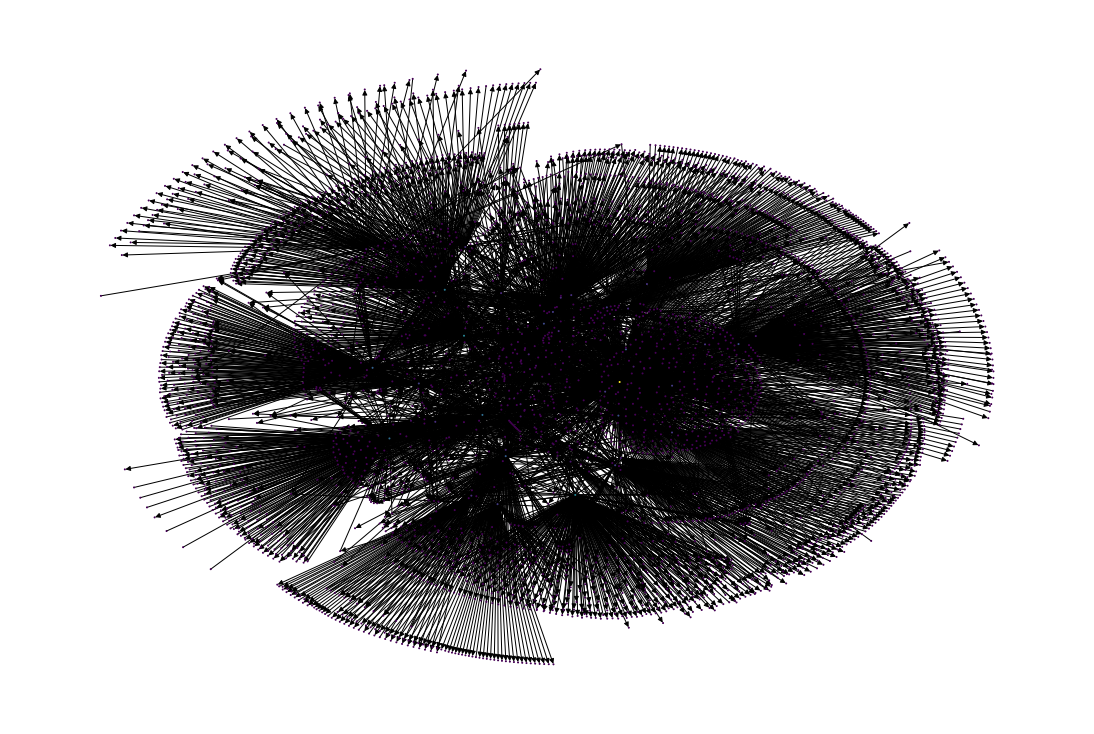

In [7]:
nx.draw(citation,
        pos=graphviz_layout(citation),
        node_size=1,
        node_color=[float(i) for i in dict(nx.degree(citation)).values()])
plt.savefig('citation_centrality.pdf')

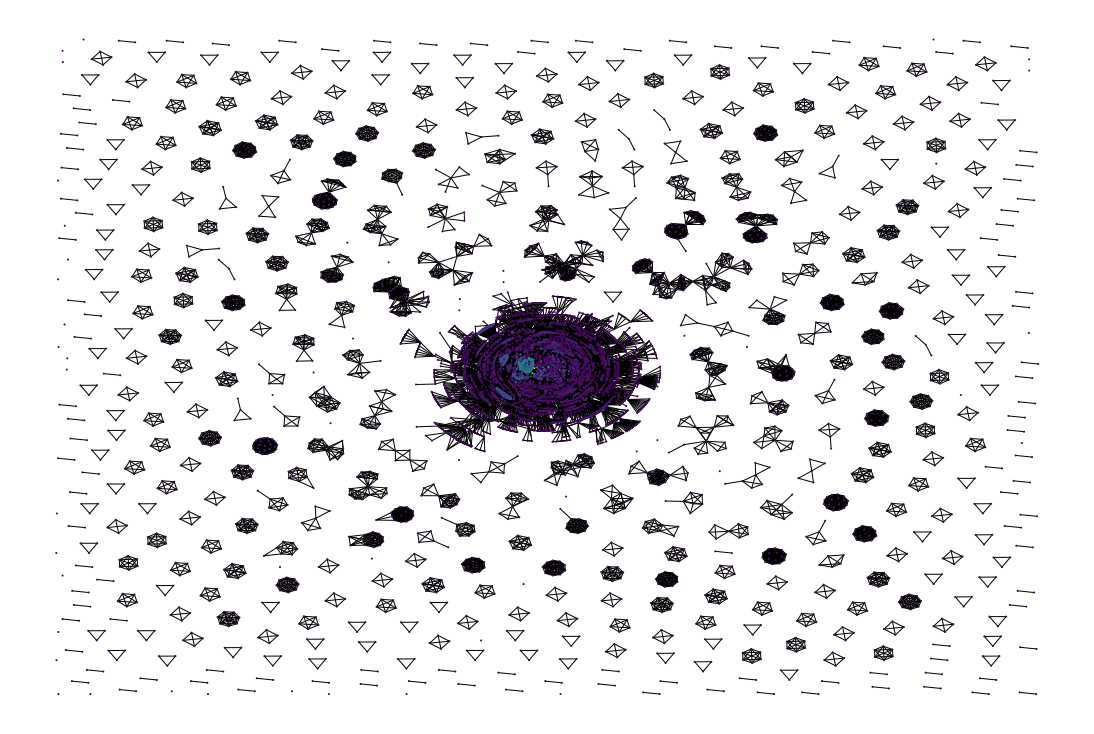

In [8]:
nx.draw(collaboration,
        pos=graphviz_layout(collaboration),
        node_size=1,
        node_color=[float(i) for i in dict(nx.degree(collaboration)).values()])
plt.savefig('collaboration_centrality.pdf')

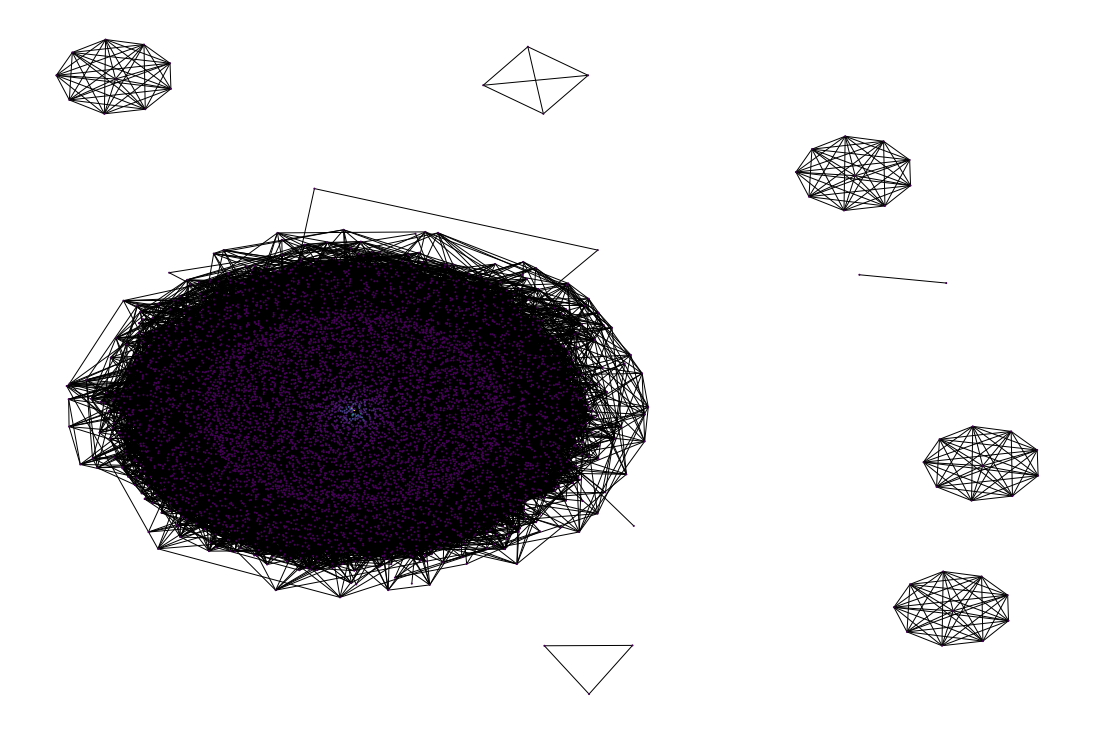

In [9]:
nx.draw(keyword_graph,
        pos=graphviz_layout(keyword_graph),
        node_size=1,
        node_color=[float(i) for i in dict(nx.degree(keyword_graph)).values()])
plt.savefig('keyword_centrality.pdf')

## Distributions

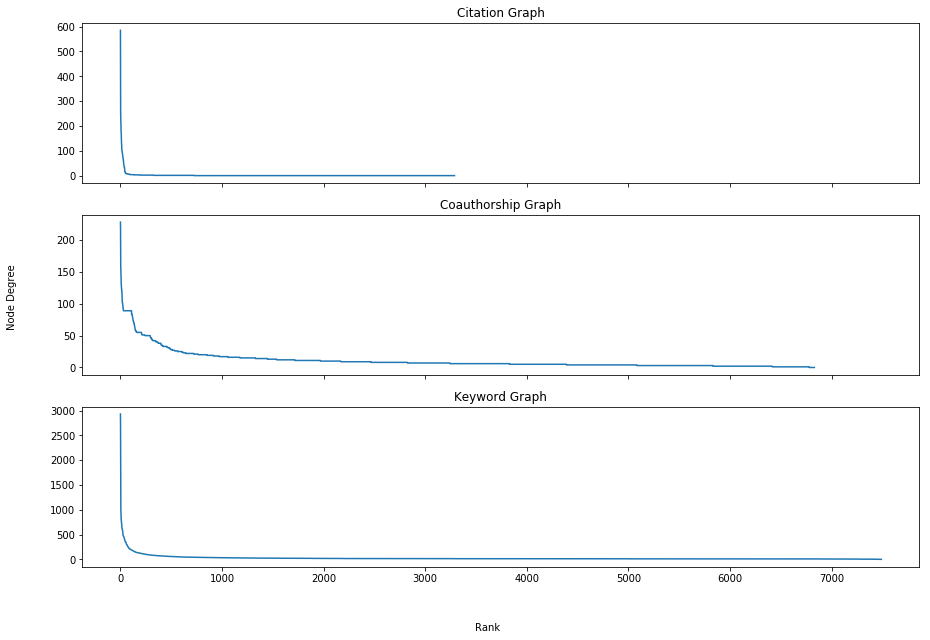

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)

ax1.plot(sorted(dict(nx.degree(citation)).values(), reverse=True))
ax1.title.set_text('Citation Graph')

ax2.plot(sorted(dict(nx.degree(collaboration)).values(), reverse=True))
ax2.title.set_text('Coauthorship Graph')

ax3.plot(sorted(dict(nx.degree(keyword_graph)).values(), reverse=True))
ax3.title.set_text('Keyword Graph')

fig.text(0.06, 0.5, 'Node Degree', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Rank', ha='center', va='center')

plt.savefig('degree_distributions.pdf')

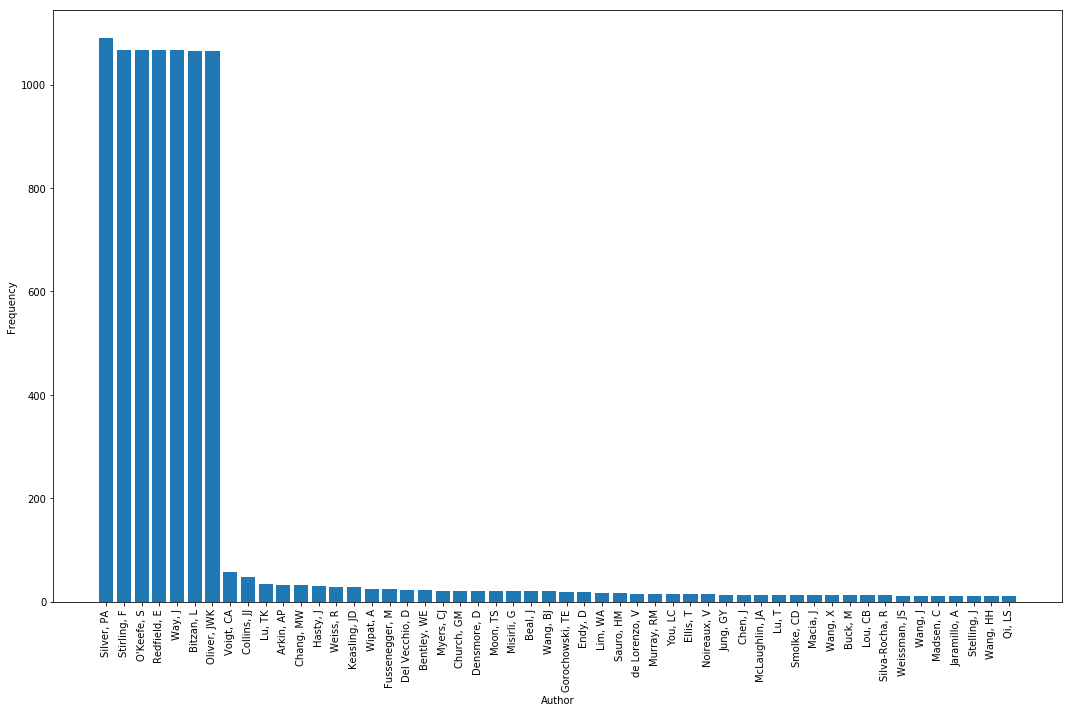

In [11]:
fig, ax = plt.subplots(1,1)


author_count = Counter(';'.join(nx.get_node_attributes(citation, 'authors').values()).split(';'))
author_count = {i:j for i,j in author_count.items() if j > 10}
author_count = dict(sorted(author_count.items(), key=lambda item: item[1], reverse=True))
ax.bar(author_count.keys(), author_count.values())
ax.set_xticklabels(author_count.keys(), rotation='vertical')
ax.set_xlabel('Author')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig('barplot_authors.pdf')

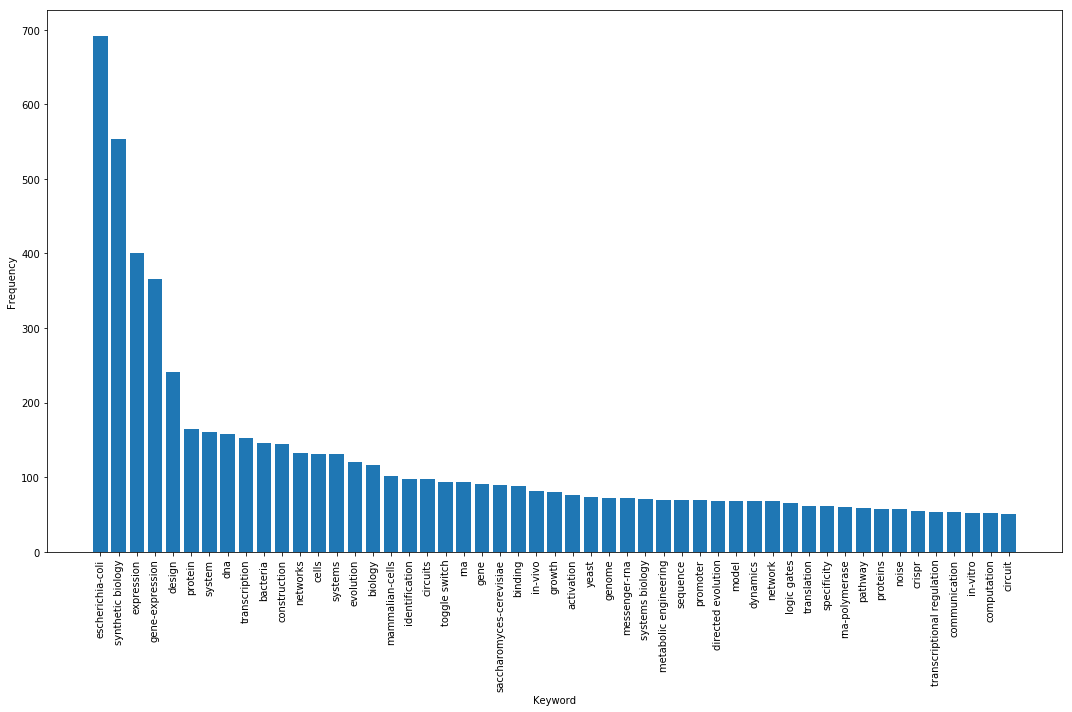

In [12]:
fig, ax = plt.subplots(1,1)


keyword_count = Counter(';'.join(nx.get_node_attributes(citation, 'keywords').values()).split(';'))
keyword_count = {i:j for i,j in keyword_count.items() if j > 50 and i != ''}
keyword_count = dict(sorted(keyword_count.items(), key=lambda item: item[1], reverse=True))
ax.bar(keyword_count.keys(), keyword_count.values())
ax.set_xticklabels(keyword_count.keys(), rotation='vertical')
ax.set_xlabel('Keyword')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig('barplot_keywords.pdf')

24


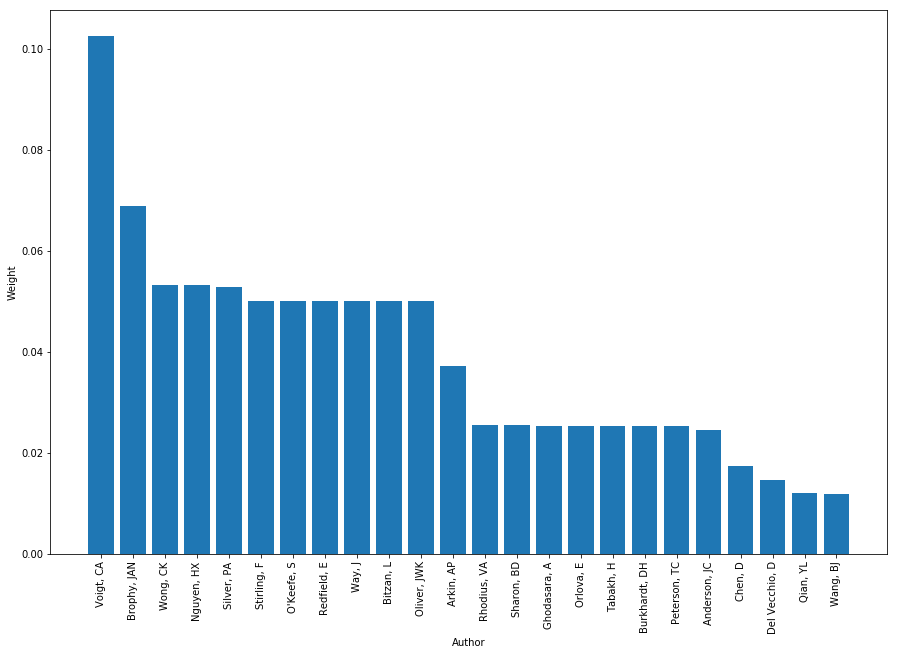

In [14]:
in_degrees, out_degrees = nx.in_degree_centrality(citation), nx.out_degree_centrality(citation)

author_in_degree = {}

fig, ax = plt.subplots(1,1)

for node in citation.nodes():
    for author in all_authors[node].split(';'):
        if author in author_in_degree.keys():
            author_in_degree[author] += in_degrees[node] / len(all_authors[node].split(';'))
        else:
            author_in_degree[author] = in_degrees[node]

author_in_degree = {i:j for i,j in author_in_degree.items() if j > 0.01 and i != ''}
print(len(author_in_degree))
author_in_degree = dict(sorted(author_in_degree.items(), key=lambda item: item[1], reverse=True))
ax.bar(author_in_degree.keys(), author_in_degree.values())
ax.set_xticklabels(author_in_degree.keys(), rotation='vertical')
ax.set_xlabel('Author')
ax.set_ylabel('Weight')
plt.savefig('barplot_author_in_degree.pdf')

## Maximal Cliques

DescribeResult(nobs=2075, minmax=(1, 90), mean=5.582168674698795, variance=21.853780251187974, skewness=5.873748377733594, kurtosis=71.25635070908314)

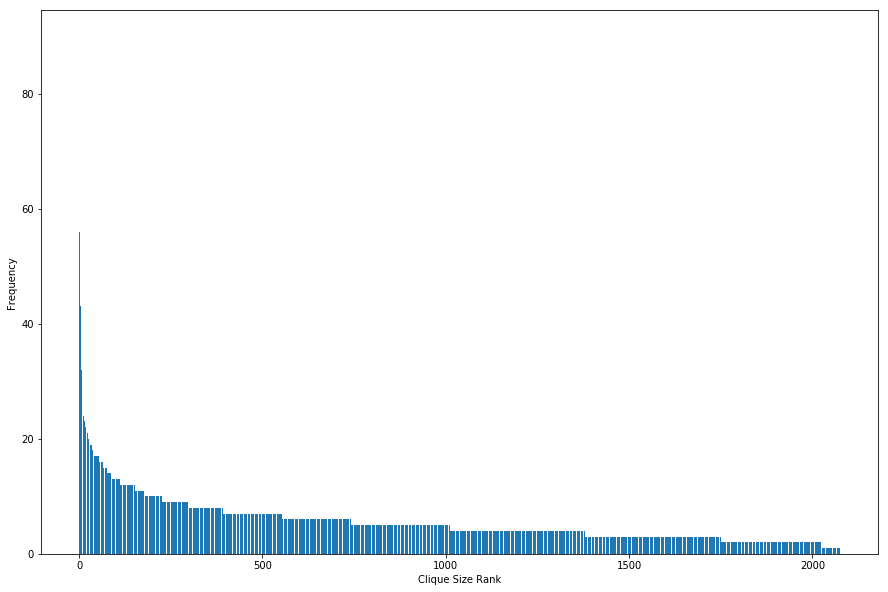

In [15]:
# Maximal Cliques
g = nx.read_graphml('coauthorship_graph.graphml')

m_cliques = []
for component in nx.connected_components(g):
    for clique in maximal_cliques(g.subgraph(component)):
        m_cliques.append(clique)

plt.bar(range(len(m_cliques)), sorted([len(m) for m in m_cliques], reverse=True))
plt.ylabel('Frequency')
plt.xlabel('Clique Size Rank')
plt.savefig('Clique Distribution')
describe([len(m) for m in m_cliques])

## Association Rules

In [16]:
dataset = []

for node in citation.nodes():
    transaction = all_authors[node].split(';') + all_keywords[node].split(';')
    transaction = [t for t in transaction if t]
    if transaction:
        dataset.append(transaction)

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = fpgrowth(df, min_support=0.0009, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.95)

filter_rules = rules[rules['antecedents'].apply(len) == 1]
filter_rules = filter_rules[filter_rules['consequents'].apply(len) == 1]
filter_rules = filter_rules[filter_rules['consequents'].apply(lambda n:\
                                                              bool(set(n).intersection(keyword_graph.nodes())))]
filter_rules = filter_rules[filter_rules['antecedents'].apply(lambda n:\
                                                              bool(set(n).intersection(collaboration.nodes())))]

d = Digraph('author_topics.pdf', engine='fdp')

for i, row in filter_rules.iterrows():
    d.node(list(row['antecedents'])[0], shape='rectangle')
    d.edge(list(row['antecedents'])[0], list(row['consequents'])[0])
d.view()

filter_rules.to_csv('filtered_rules.csv')
filter_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2042,"(Prather, KLJ)",(escherichia-coli),0.001824,0.210398,0.001824,1.0,4.752890,0.001440,inf
2050,"(Chen, XY)",(escherichia-coli),0.000912,0.210398,0.000912,1.0,4.752890,0.000720,inf
2431,"(Woo, HM)",(synthetic biology),0.001520,0.168136,0.001520,1.0,5.947559,0.001265,inf
2434,"(Lee, TS)",(escherichia-coli),0.001216,0.210398,0.001216,1.0,4.752890,0.000960,inf
2710,"(Der, BS)",(synthetic biology),0.001520,0.168136,0.001520,1.0,5.947559,0.001265,inf
...,...,...,...,...,...,...,...,...,...
68121,"(Venturelli, OS)",(escherichia-coli),0.000912,0.210398,0.000912,1.0,4.752890,0.000720,inf
68189,"(Carter, KK)",(quorum sensing),0.000912,0.010946,0.000912,1.0,91.361111,0.000902,inf
68190,"(Carter, KK)",(synthetic biology),0.000912,0.168136,0.000912,1.0,5.947559,0.000759,inf
68213,"(Valdes, JJ)",(quorum sensing),0.000912,0.010946,0.000912,1.0,91.361111,0.000902,inf


## Timeseries

In [ ]:
key_time_dict = {}

print('Building key_time_dict')
for node in citation.nodes():
    for word in all_keywords[node].split(';'):
        if word in key_time_dict.keys():
            key_time_dict[word].append(citation.nodes[node]['year'])
        else:
            key_time_dict[word] = [citation.nodes[node]['year']]

print('Filtering')
key_time_dict = {k:v for k,v in key_time_dict.items() if len(v) > 145 and bool(k)}            

print('Plotting', len(key_time_dict))
for k in key_time_dict:
    d = Counter(key_time_dict[k])
    x = sorted(d.keys())
    y = np.cumsum([d[i] for i in x])
    plt.plot(x,y, label=k)
plt.legend(loc="upper left")
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.savefig('keyword_timeseries.pdf')

In [ ]:
plt.bar(*zip(*Counter(nx.get_node_attributes(citation, 'year').values()).items()))
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.savefig('all_keyword_timeseries.pdf')

## Association Between In vs Out Degree

In [ ]:
x,y= [], []
for node in citation.nodes():
    x.append(in_degrees[node])
    y.append(out_degrees[node])

    
plt.scatter(x,y)
r,p = pearsonr(x,y)
plt.title(f'r={round(r, 3)} p={round(p, 3)}')
plt.xlabel('In Degree')
plt.ylabel('Out Degree')
plt.savefig('scatterplot_in_vs_out_degree.pdf')

## Article Importance

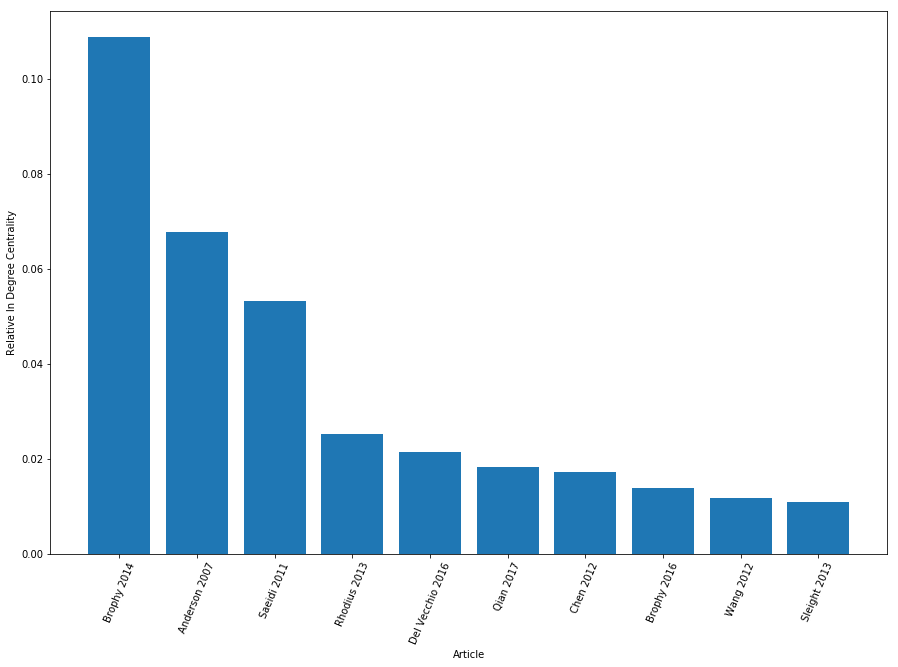

In [57]:
papers = []

for node in citation.nodes():
    papers.append((f"{all_authors[node].split(';')[0].split(',')[0]} {all_years[node]}", in_degrees[node]))

papers = dict([i for i in papers if i[1] > 0.01])
papers = dict(sorted(papers.items(), key=lambda item: item[1], reverse=True))

plt.bar(papers.keys(),papers.values())
plt.xticks(rotation='67')
plt.xlabel('Article')
plt.ylabel('Relative In Degree Centrality')
plt.savefig('article_in_degree.pdf')